# **Hospital Readmission Prediction - Feature Engineering**

This notebook focuses on feature engineering for the hospital readmission prediction model. We'll transform raw features into more informative ones and prepare the data for modeling.

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import warnings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

## 1. **Load the Data**

In [291]:
data = pd.read_csv('diabetic_data.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# 2. **Basic Preprocessing**

In [292]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 50)


In [293]:
data['encounter_count'] = data.groupby('patient_nbr')['encounter_id'].transform('count')


##Removed columns with over 40% missing data.

---



In [294]:
import numpy as np
import pandas as pd
data = data.replace('?', np.nan)
missing_threshold = 0.4
high_missing = data.columns[data.isnull().mean() > missing_threshold]
print("Columns with more than 40% missing values:")
print(high_missing.tolist())
data.drop(columns=high_missing, inplace=True)

Columns with more than 40% missing values:
['weight', 'medical_specialty', 'max_glu_serum', 'A1Cresult']


In [295]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 47)


In [296]:
missing_count = data.isna().sum()
missing_percent = (data.isna().mean() * 100).round(2)
missing_info = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent
})
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_info)

            Missing Count  Missing %
payer_code          40256      39.56
race                 2273       2.23
diag_3               1423       1.40
diag_2                358       0.35
diag_1                 21       0.02


##Missing values in the 'payer_code' and 'race' columns have been imputed using the mode.

In [297]:
for col in ['payer_code', 'race']:
    mode_val = data[col].mode()[0]
    data[col] = data[col].fillna(mode_val)

In [298]:
cols = ['diag_1', 'diag_2', 'diag_3']
total_nans = data[cols].isna().sum().sum()
print("Total NaN values in diag_1, diag_2, and diag_3:", total_nans)

Total NaN values in diag_1, diag_2, and diag_3: 1802


##Missing values in the three diagnosis columns were imputed with '00'.

In [299]:
cols = ['diag_1', 'diag_2', 'diag_3']
data[cols] = data[cols].fillna('Unknown')

In [300]:
cols = ['diag_1', 'diag_2', 'diag_3']
total_nans = data[cols].isna().sum().sum()
print("Total NaN values in diag_1, diag_2, and diag_3:", total_nans)

Total NaN values in diag_1, diag_2, and diag_3: 0


# 3. **Feature Engineering**

##Created a 'VisitType' feature by classifying visit patterns from inpatient, outpatient, and emergency columns. Dropped original columns after transformation.

In [301]:
# import pandas as pd
# def classify_visit(row):
#     inpatient = row['number_inpatient']
#     outpatient = row['number_outpatient']
#     emergency = row['number_emergency']

#     if emergency > 0:
#         return 'emergency'
#     elif inpatient > 10:
#         return 'high_inpatient'
#     elif inpatient > 0:
#         return 'low_inpatient'
#     elif outpatient >= 19:
#         return 'high_outpatient_rate'
#     elif outpatient > 0:
#         return 'low_outpatient_rate'
#     else:
#         return 'novisit'
# data['VisitType'] = data.apply(classify_visit, axis=1)
# data.drop(['number_inpatient', 'number_outpatient', 'number_emergency'], axis=1, inplace=True)

**This code maps numeric admission_type_id values to readable category labels (like 'Emergency', 'Elective', etc.) using a dictionary, creates a new column admission_type with these labels, and then drops the original admission_type_id column.**

In [302]:
# Map admission_type_id to descriptive labels
admission_type_map = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Unknown',  # Previously 'Not Available'
    6: 'Unknown',  # Previously 'NULL'
    7: 'Trauma Center',
    8: 'Unknown'   # Previously 'Not Mapped'
}

# Apply mapping and drop original column
data['admission_type'] = data['admission_type_id'].map(admission_type_map)
data.drop(columns=['admission_type_id'], inplace=True)


In [303]:
data['admission_group'] = data['admission_type'].map({
    'Emergency': 'Unplanned',
    'Urgent': 'Unplanned',
    'Elective': 'Planned',
    'Unknown': 'Unknown',  # includes NULL, Not Available
})


**This line creates a new column expiration_ind that flags whether a patient's discharge disposition indicates death (based on specific ID values). It assigns 1 if true (i.e., patient expired) and 0 otherwise.**

In [304]:
data['expiration_ind'] = data['discharge_disposition_id'].isin([11,13,14,19,20,21]).astype('int')

 discharge_disposition_id column

**This code maps the discharge_disposition_id values to broader categories (like 'Home', 'Transferred Hospital', etc.) using discharge_group_map, then creates a new column discharge_group with these values. It finally drops the original discharge_disposition_id column for simplification.**

In [305]:
discharge_group_map = {
    1: 'Home',
    6: 'Home',
    8: 'Home',

    3: 'SNF/ICF/Rehab',
    4: 'SNF/ICF/Rehab',
    22: 'SNF/ICF/Rehab',
    23: 'SNF/ICF/Rehab',
    24: 'SNF/ICF/Rehab',
    15: 'SNF/ICF/Rehab',

    2: 'Transferred Hospital',
    5: 'Transferred Hospital',
    27: 'Transferred Hospital',
    28: 'Transferred Hospital',
    29: 'Transferred Hospital',
    30: 'Transferred Hospital',

    12: 'Outpatient Follow-up',
    16: 'Outpatient Follow-up',
    17: 'Outpatient Follow-up',

    9: 'Inpatient Readmit',
    7: 'Left AMA',

    18: 'Unknown/Invalid',
    25: 'Unknown/Invalid',
    26: 'Unknown/Invalid'
}

# Apply mapping
data['discharge_group'] = data['discharge_disposition_id'].map(discharge_group_map)

data.drop(['discharge_disposition_id'], axis=1, inplace=True)

**This code maps the admission_source_id values to descriptive labels (such as 'Physician Referral', 'Emergency Room', etc.) using the admission_source_id dictionary. It then creates a new column admission_source_grouped with these mapped values and drops the original admission_source_id column.**

In [306]:
admission_source_id = { 1 : 'Physician Referral'
, 2 : 'Clinic Referral'
, 3 : 'HMO Referral'
, 4 : 'Transfer from a hospital'
, 5 : 'Transfer from a Skilled Nursing Facility (SNF)'
, 6 : 'Transfer from another health care facility'
, 7 : 'Emergency Room'
, 8 : 'Court/Law Enforcement'
, 9 :  'Not Available'
, 10 : 'Transfer from critial access hospital'
, 11 : 'Normal Delivery'
, 12 : 'Premature Delivery'
, 13 : 'Sick Baby'
, 14 : 'Extramural Birth'
, 15 : 'Not Available'
, 17 : 'NULL'
, 18 : 'Transfer From Another Home Health Agency'
, 19 : 'Readmission to Same Home Health Agency'
, 20 : 'Not Mapped'
, 21 : 'Unknown/Invalid'
, 22 : 'Transfer from hospital inpt/same fac reslt in a sep claim'
, 23 : 'Born inside this hospital'
, 24 : 'Born outside this hospital'
, 25 : 'Transfer from Ambulatory Surgery Center'
, 26 : 'Transfer from Hospice'
                      }
# Apply mapping
data['admission_source_grouped'] = data['admission_source_id'].map(admission_source_id)
data.drop(['admission_source_id'], axis=1, inplace=True)

In [307]:
data['is_clinic_or_transfer'] = data['admission_source_grouped'].isin([
    'Clinic Referral',
    'Transfer from a hospital',
    'Transfer from another health care facility'
]).astype(int)


**This code creates multiple new indicator columns based on the admission_type and discharge_group columns, grouping them into categories like 'Emergency', 'Elective', and 'Home' vs 'Transferred Hospital'. It then aggregates the counts of these grouped categories at the patient level (using groupby on patient_nbr), creating columns like mb_admission_grp_1_ct and mb_discharge_grp_1_ct to capture the frequency of these categories for each patient.**

In [308]:
data['admission_grp_1_ind'] = data['admission_type'].isin(['Emergency', 'Unknown']).astype(int)
data['admission_grp_2_ind'] = data['admission_type'].isin(['Elective', 'Trauma Center']).astype(int)

data['discharge_grp_1_ind'] = data['discharge_group'].isin([
    'Home', 'SNF/ICF/Rehab', 'Unknown/Invalid'
]).astype(int)

data['discharge_grp_2_ind'] = data['discharge_group'].isin([
    'Left AMA', 'Transferred Hospital', 'Inpatient Readmit', 'Outpatient Follow-up'
]).astype(int)

data['admission_type_ind'] = data['admission_source_grouped'].isin([
    'Clinic Referral', 'Transfer from a hospital', 'Transfer from another health care facility'
]).astype(int)


In [309]:
data['mb_admission_grp_1_ct'] = data.groupby('patient_nbr')['admission_grp_1_ind'].transform('sum')
data['mb_admission_grp_2_ct'] = data.groupby('patient_nbr')['admission_grp_2_ind'].transform('sum')
data['mb_discharge_grp_1_ct'] = data.groupby('patient_nbr')['discharge_grp_1_ind'].transform('sum')
data['mb_discharge_grp_2_ct'] = data.groupby('patient_nbr')['discharge_grp_2_ind'].transform('sum')
data['mb_admission_type_ct']  = data.groupby('patient_nbr')['admission_type_ind'].transform('sum')


In [310]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 60 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   time_in_hospital          101766 non-null  int64 
 6   payer_code                101766 non-null  object
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_outpatient         101766 non-null  int64 
 11  number_emergency          101766 non-null  int64 
 12  number_inpatient          101766 non-null  int64 
 13  diag_1                    101766 non-null  object
 14  diag

**This code combines the diag_1, diag_2, and diag_3 columns into a single column using melt. It then counts the number of unique diagnoses for each patient and stores the result in the distinct_diag_count column. After that, it merges this count back into the original data DataFrame. Finally, it deletes the temporary variables diagnosis_melted and distinct_counts to clean up memory.**

In [311]:
# Combine diag_1, diag_2, diag_3 into one column
diagnosis_melted = data.melt(id_vars=['patient_nbr'], value_vars=['diag_1', 'diag_2', 'diag_3'])

# Count number of unique diagnoses per patient
distinct_counts = diagnosis_melted.groupby('patient_nbr')['value'].nunique().reset_index()

# Step 3: Rename the column for clarity
distinct_counts.columns = ['patient_nbr', 'distinct_diag_count']

# Step 4: Merge the count back to the original dataset
data = data.merge(distinct_counts, on='patient_nbr', how='left')

# Step 5: Clean up temp variables
del diagnosis_melted, distinct_counts

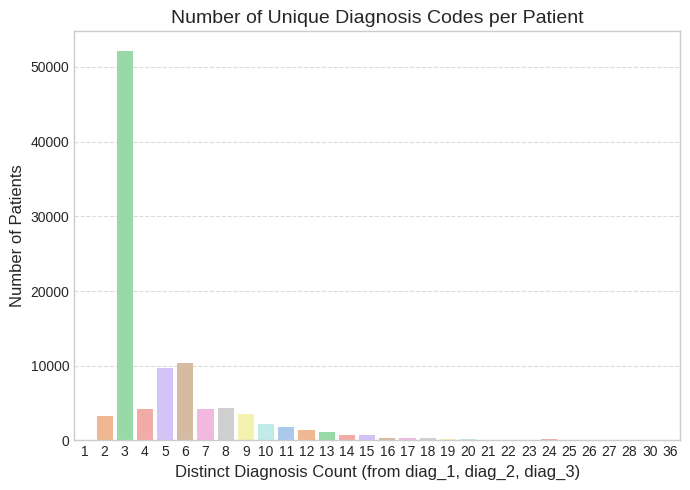

In [312]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size
plt.figure(figsize=(7, 5))

# Plot histogram of distinct diagnosis counts
sns.countplot(x='distinct_diag_count', data=data, palette='pastel')

# Titles and labels
plt.title('Number of Unique Diagnosis Codes per Patient', fontsize=14)
plt.xlabel('Distinct Diagnosis Count (from diag_1, diag_2, diag_3)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**This code first loads a CSV file containing a mapping of diagnosis codes to their descriptions (unique_diag_df_edit.csv). It then creates a dictionary (diag_map_dict) where the diagnosis codes are the keys, and their descriptions are the values. The diag_1, diag_2, and diag_3 columns in the data DataFrame are mapped to their corresponding descriptions using this dictionary. Additionally, the code calculates the frequency of each diagnosis code in diag_1, diag_2, and diag_3 and adds these frequencies as new columns (diag_1_freq, diag_2_freq, and diag_3_freq) to the data DataFrame.**

In [313]:
import pandas as pd

# Load mapping CSV
diag_map_df = pd.read_csv('unique_diag_df_edit.csv')

# Display first few rows to verify
print(diag_map_df.head())

diag_map_dict = diag_map_df.set_index('diagnosis_cd')['diagnosis'].to_dict()

data['diag_1_desc'] = data['diag_1'].map(diag_map_dict)
data['diag_2_desc'] = data['diag_2'].map(diag_map_dict)
data['diag_3_desc'] = data['diag_3'].map(diag_map_dict)

# Calculate frequency of each diagnosis code for diag_1, diag_2, and diag_3
data['diag_1_freq'] = data.groupby('diag_1')['diag_1'].transform('count')
data['diag_2_freq'] = data.groupby('diag_2')['diag_2'].transform('count')
data['diag_3_freq'] = data.groupby('diag_3')['diag_3'].transform('count')


  diagnosis_cd                 diagnosis
0            3      SALMONELLA ENTERITIS
1            5      STAPH FOOD POISONING
2            7             BALANTIDIASIS
3            8   INTEST INFEC E COLI NOS
4            9  INFECTIOUS ENTERITIS NOS


In this section, we preprocess the diagnosis

columns (diag_1, diag_2, diag_3) by performing the following steps:

Convert to String & Handle Missing Values: Convert diagnosis columns to strings and fill missing values with 'UNK'.

Create Diagnosis Array: Combine the three diagnosis columns into a list (diagnosis_array) and sort it for consistency.

Convert to Tuples: Convert the sorted diagnosis array into tuples for grouping purposes.

Count Frequency of Diagnosis Tuples: Count how often each unique diagnosis combination appears.

Assign Sorted Diagnoses: Separate the sorted diagnosis codes into new columns (diag_1_sort, diag_2_sort, diag_3_sort).

Calculate Frequency by Position: Calculate the frequency of each diagnosis code at each position.

Clean Up Temporary Columns: Drop temporary columns used during the process.

Map to Descriptions: Map the diagnosis codes to descriptive labels using the diag_map_dict.

Optimize Memory: Delete the mapping dictionary to save memory.

This process ensures the diagnosis data is clean, consistent, and ready for further analysis.

In [314]:
# Step 1: Convert diagnosis columns to string and fill NaNs with 'UNK'
data[['diag_1', 'diag_2', 'diag_3']] = data[['diag_1', 'diag_2', 'diag_3']].fillna('UNK').astype(str)

# Step 2: Create 'diagnosis_array' column (a list of diag_1, diag_2, diag_3)
data['diagnosis_array'] = data[['diag_1', 'diag_2', 'diag_3']].values.tolist()

# Step 3: Sort 'diagnosis_array'
data['diagnosis_array'] = data['diagnosis_array'].apply(sorted)

# Step 4: Convert list to tuple (to make it hashable for groupby)
data['diagnosis_array_tuple'] = data['diagnosis_array'].apply(tuple)

# Step 5: Count frequency of each diagnosis tuple
data['diagnosis_tuple_freq'] = data.groupby('diagnosis_array_tuple')['diagnosis_array_tuple'].transform('count')

# Step 6: Assign sorted elements back to individual columns
data[['diag_1_sort', 'diag_2_sort', 'diag_3_sort']] = pd.DataFrame(data['diagnosis_array'].tolist(), index=data.index)

# Step 7: Calculate frequency of each diagnosis code in each position
data['diag_1_sort_freq'] = data.groupby('diag_1_sort')['diag_1_sort'].transform('count')
data['diag_2_sort_freq'] = data.groupby('diag_2_sort')['diag_2_sort'].transform('count')
data['diag_3_sort_freq'] = data.groupby('diag_3_sort')['diag_3_sort'].transform('count')

# Step 8: Drop temporary 'diagnosis_array_tuple' column
data.drop(columns=['diagnosis_array_tuple'], inplace=True)

# Step 9: Reformat diagnosis_array as a string tuple
data['diagnosis_tuple'] = data['diagnosis_array'].apply(lambda x: f"({' '.join(x)})")

# Step 10: Drop temporary diagnosis_array list
data.drop(columns=['diagnosis_array'], inplace=True)

# Step 11: Map diagnosis codes to descriptive labels using a dictionary
# Ensure diag_map_dict is defined beforehand (e.g., loaded from CSV)
data['diagnosis_1_sort'] = data['diag_1_sort'].map(diag_map_dict)
data['diagnosis_2_sort'] = data['diag_2_sort'].map(diag_map_dict)
data['diagnosis_3_sort'] = data['diag_3_sort'].map(diag_map_dict)

# Step 12: Optionally delete the dictionary to save memory
del diag_map_dict


**The code creates a new dataframe dx_events with diagnosis indicator columns for each code in dx_list. It fills missing diagnosis fields, checks if each code appears in any of the diagnosis columns (diag_1, diag_2, diag_3), and adds an indicator for each diagnosis code. Finally, it prints the shape of the dataframe.**

In [315]:
dx_list=[ '428'
, '403'
, '707'
, '585'
, '491'
, '396'
, '440'
, '453'
, '571'
, '284'
, '304'
, '482'
, '150'
, '282'
, '332'
, '443'
, '719'
, '423'
, '281'
, '536'
, '368'
, '515'
, '595'
, '572'
, '681'
, '581'
, '537'
, '490'
, '583'
, 'V46'
, '519'
, '300'
, '567'
, 'E92'
, 'V49'
, '094'
, '514'
, '494'
, '042'
, '404'
, '346'
, '792'
, '398'
, '753'
, '577'
, '730'
, '444'
, '459'
, '790'
, '337'
, '397'
, '292'
, 'V42'
, '289']

In [316]:
# Create dx_events with the selected columns
dx_events = data[['patient_nbr', 'encounter_id', 'diag_1', 'diag_2', 'diag_3']].copy(deep=True)

# Fill missing diagnosis fields with empty strings for safe comparison
dx_events[['diag_1', 'diag_2', 'diag_3']] = dx_events[['diag_1', 'diag_2', 'diag_3']].astype(str).fillna('')

# For each diagnosis code in dx_list, create an indicator column
for dx in dx_list:
    dx_events[f'dx_{dx}_ind'] = dx_events[['diag_1', 'diag_2', 'diag_3']].apply(
        lambda row: int(dx in row.values), axis=1
    )

# Show the final shape
print(dx_events.shape)


(101766, 59)


In [317]:
# Ensure diag_1 to diag_3 are strings (for comparison)
data[['diag_1', 'diag_2', 'diag_3']] = data[['diag_1', 'diag_2', 'diag_3']].astype(str).fillna('')

# Populate each column with 1 if the diagnosis appears, else 0
for dx in dx_list:
    data[f'dx_{dx}_ind'] = ((data['diag_1'] == dx) |
                            (data['diag_2'] == dx) |
                            (data['diag_3'] == dx)).astype(int)

print('done')


done


**The code groups the data by patient_nbr and computes the maximum and sum for each diagnosis indicator in dx_list. The resulting columns are renamed to a SQL-style format (e.g., dx_XXX_ind_max, dx_XXX_ind_sum). The grouped data is then saved to a CSV file and the original indicator columns are removed from the data to save memory.**

In [318]:
# Group by patient_nbr and compute max and sum for each diagnosis indicator
dx_aggregated = data.groupby('patient_nbr').agg(
    {f'dx_{dx}_ind': ['max', 'sum'] for dx in dx_list}
)

# Rename columns to SQL-style naming: dx_XXX_ind_max, dx_XXX_ind_sum
dx_aggregated.columns = [f'{col[0]}_{col[1]}' for col in dx_aggregated.columns]

# Reset index to bring patient_nbr back as a column
dx_aggregated = dx_aggregated.reset_index()

# Save to CSV
dx_aggregated.to_csv('dx_aggregated_ck.csv', index=False)

# Optional: remove the original indicators from the main dataset to save memory
for dx in dx_list:
    del data[f'dx_{dx}_ind']


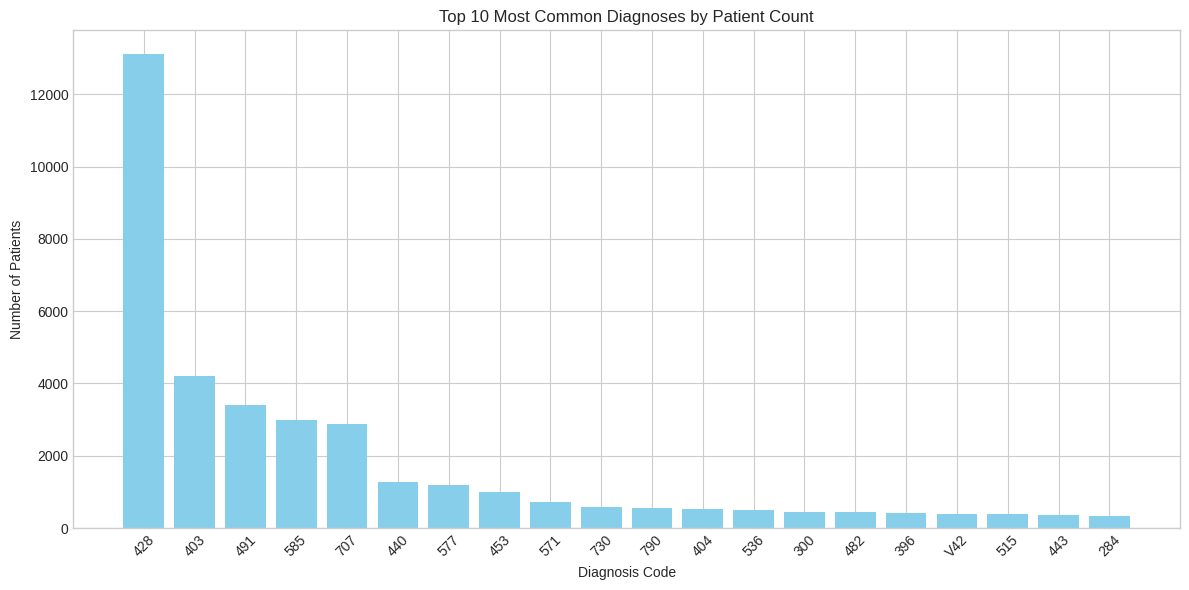

In [319]:
import matplotlib.pyplot as plt

# Extract only 'max' columns (whether patient ever had the diagnosis)
max_cols = [col for col in dx_aggregated.columns if col.endswith('_max')]

# Sum each max column to get patient counts
diagnosis_counts = dx_aggregated[max_cols].sum().sort_values(ascending=False)

# Convert column names back to diagnosis codes for display
diagnosis_codes = [col.replace('dx_', '').replace('_ind_max', '') for col in diagnosis_counts.index]

# Plot
plt.figure(figsize=(12,6))
plt.bar(diagnosis_codes[:20], diagnosis_counts.values[:20], color='skyblue')
plt.title("Top 10 Most Common Diagnoses by Patient Count")
plt.xlabel("Diagnosis Code")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [320]:
# Print original shape of data
print(data.shape)

# Merge dx_aggregated into data based on patient_nbr
data = data.merge(dx_aggregated, on='patient_nbr', how='left')

# Print new shape after merge
print(data.shape)

# Clean up to free memory
del dx_aggregated


(101766, 78)
(101766, 186)


**The code creates three new indicator columns (alcohol_ind, obesity_ind, mh_ind) by checking if the diagnosis descriptions contain the respective terms ("ALCOHOL", "OBESITY", "MALIGNANT HYPERTENSION") in any of the diagnosis columns (diagnosis_1_sort, diagnosis_2_sort, diagnosis_3_sort). If any of these terms are found, the corresponding indicator is set to 1; otherwise, it is set to 0.**

In [321]:
# Alcohol indicator
data['alcohol_ind'] = data[['diagnosis_1_sort', 'diagnosis_2_sort', 'diagnosis_3_sort']].apply(
    lambda row: int(any('ALCOHOL' in str(val).upper() for val in row)), axis=1
)

# Obesity indicator
data['obesity_ind'] = data[['diagnosis_1_sort', 'diagnosis_2_sort', 'diagnosis_3_sort']].apply(
    lambda row: int(any('OBESITY' in str(val).upper() for val in row)), axis=1
)

# Malignant Hypertension indicator
data['mh_ind'] = data[['diagnosis_1_sort', 'diagnosis_2_sort', 'diagnosis_3_sort']].apply(
    lambda row: int(any('MALIGNANT HYPERTENSION' in str(val).upper() for val in row)), axis=1
)


In [322]:
# Initialize the drop list
drop = []

# Create history indicators by grouping on 'patient_nbr' and taking the max value
data['alcohol_history_ind'] = data.groupby('patient_nbr')['alcohol_ind'].transform('max')
data['obesity_history_ind'] = data.groupby('patient_nbr')['obesity_ind'].transform('max')
data['mh_history_ind'] = data.groupby('patient_nbr')['mh_ind'].transform('max')

# Add the individual indicator columns to the drop list
drop.extend(['alcohol_ind', 'obesity_ind', 'mh_ind'])

# Drop the columns from the dataframe
data.drop(columns=drop, inplace=True)

In [323]:
# Create a binary indicator for whether the patient was admitted or not
data['admitted_ind'] = (data['readmitted'] != 'NO').astype(int)

**The code creates new patient-level features by aggregating data for each patient using groupby on the patient_nbr column. It calculates the total counts of various factors, such as the number of encounters (encounter_ct), time spent in the hospital (mb_time_in_hospital), readmissions (mb_readmitted_ct), lab procedures (mb_num_lab_procedures_ct), medications (mb_num_medications_ct), and more. These aggregated values are added as new columns to the dataset.**

In [324]:
# Add patient-level features
data['encounter_ct'] = data['patient_nbr'].map(data.groupby('patient_nbr')['encounter_id'].nunique())
data['mb_time_in_hospital'] = data.groupby('patient_nbr')['time_in_hospital'].transform('sum')
data['mb_readmitted_ct'] = data.groupby('patient_nbr')['admitted_ind'].transform('sum')
data['mb_num_lab_procedures_ct'] = data.groupby('patient_nbr')['num_lab_procedures'].transform('sum')
data['mb_num_procedures_ct'] = data.groupby('patient_nbr')['num_procedures'].transform('sum')
data['mb_num_medications_ct'] = data.groupby('patient_nbr')['num_medications'].transform('sum')
data['mb_number_outpatient_ct'] = data.groupby('patient_nbr')['number_outpatient'].transform('sum')
data['mb_number_emergency_ct'] = data.groupby('patient_nbr')['number_emergency'].transform('sum')
data['mb_number_inpatient_ct'] = data.groupby('patient_nbr')['number_inpatient'].transform('sum')
data['mb_number_diagnoses_ct'] = data.groupby('patient_nbr')['number_diagnoses'].transform('sum')

##Age Column

In [325]:
# Create age group indicators
data['under10_ind'] = data['age'].isin(['[0-10)']).astype(int)
data['over80_ind'] = data['age'].isin(['[80-90)', '[90-100)']).astype(int)

# Add patient-level features based on age group indicators
data['mb_under10_ind'] = data.groupby('patient_nbr')['under10_ind'].transform('max')
data['mb_over80_ind'] = data.groupby('patient_nbr')['over80_ind'].transform('max')

# Drop unnecessary columns
drop_columns = ['under10_ind', 'over80_ind']
data.drop(columns=drop_columns, inplace=True)


In [326]:
print(data.shape)

# Remove very young and very old members, members who died, unknown gender
data = data[
    (data['expiration_ind'] != 1) &
    (data['mb_under10_ind'] != 1) &
    (data['mb_over80_ind'] != 1) &
    (data['gender'] != 'Unknown/Invalid') &  # Exclude records with gender 'Unknown/Invalid'
    (data['encounter_count'] < 14)  # Exclude records with encounter count >= 14
]

print(data.shape)

# Drop columns used for filtering
drop.extend(['mb_under10_ind', 'mb_over80_ind', 'expiration_ind'])


(101766, 202)
(78743, 202)


In [327]:
for i, col in enumerate(data.columns):
    print(f"{i}: {col}")



0: encounter_id
1: patient_nbr
2: race
3: gender
4: age
5: time_in_hospital
6: payer_code
7: num_lab_procedures
8: num_procedures
9: num_medications
10: number_outpatient
11: number_emergency
12: number_inpatient
13: diag_1
14: diag_2
15: diag_3
16: number_diagnoses
17: metformin
18: repaglinide
19: nateglinide
20: chlorpropamide
21: glimepiride
22: acetohexamide
23: glipizide
24: glyburide
25: tolbutamide
26: pioglitazone
27: rosiglitazone
28: acarbose
29: miglitol
30: troglitazone
31: tolazamide
32: examide
33: citoglipton
34: insulin
35: glyburide-metformin
36: glipizide-metformin
37: glimepiride-pioglitazone
38: metformin-rosiglitazone
39: metformin-pioglitazone
40: change
41: diabetesMed
42: readmitted
43: encounter_count
44: admission_type
45: admission_group
46: expiration_ind
47: discharge_group
48: admission_source_grouped
49: is_clinic_or_transfer
50: admission_grp_1_ind
51: admission_grp_2_ind
52: discharge_grp_1_ind
53: discharge_grp_2_ind
54: admission_type_ind
55: mb_admi

## Feature Selection

In [328]:
drop=[ 'diag_1', 'diag_2', 'diag_3', 'diagnosis_tuple_freq'
, 'diag_1_freq', 'diag_2_freq', 'diag_3_freq'
,'diag_1_desc', 'diag_2_desc', 'diag_3_desc'
,  'diag_1_sort' ,'diag_2_sort' ,'diag_3_sort'
, 'diagnosis_1_sort', 'diagnosis_2_sort', 'diagnosis_3_sort'
, 'diag_1_sort_freq', 'diag_2_sort_freq', 'diag_3_sort_freq']

In [329]:
# Drop columns listed in the 'drop' list
data.drop(columns=drop, inplace=True)

# Save the cleaned and prepared DataFrame to a CSV file
data.to_csv("p004_data_MLprep.csv", index=False)

# Show the shape and column info of the final DataFrame
print(data.shape)
print(data.info())


(78743, 183)
<class 'pandas.core.frame.DataFrame'>
Index: 78743 entries, 1 to 101765
Columns: 183 entries, encounter_id to mb_over80_ind
dtypes: int64(148), object(35)
memory usage: 110.5+ MB
None


In [330]:
data.drop(['patient_nbr', 'encounter_id', 'diagnosis_tuple','readmitted'], axis=1, inplace=True)

In [331]:

X = data.drop('admitted_ind', axis=1)
y = data['admitted_ind']

In [332]:
# Step 1: Identify object columns, excluding 'readmitted'
categorical_cols = X.select_dtypes(include='object').columns  # Exclude target

# Step 2: Apply One-Hot Encoding
data_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

# Step 3: Your target column 'readmitted' stays untouched
print(data_encoded.shape)
print(data_encoded.columns)

(78743, 281)
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'encounter_count', 'expiration_ind',
       ...
       'admission_source_grouped_Not Available', 'admission_source_grouped_Not Mapped', 'admission_source_grouped_Physician Referral', 'admission_source_grouped_Sick Baby', 'admission_source_grouped_Transfer from Ambulatory Surgery Center', 'admission_source_grouped_Transfer from a Skilled Nursing Facility (SNF)', 'admission_source_grouped_Transfer from a hospital', 'admission_source_grouped_Transfer from another health care facility', 'admission_source_grouped_Transfer from critial access hospital', 'admission_source_grouped_Transfer from hospital inpt/same fac reslt in a sep claim'], dtype='object', length=281)


In [333]:
print(data_encoded.dtypes)

time_in_hospital                                                                      int64
num_lab_procedures                                                                    int64
num_procedures                                                                        int64
num_medications                                                                       int64
number_outpatient                                                                     int64
                                                                                      ...  
admission_source_grouped_Transfer from a Skilled Nursing Facility (SNF)                bool
admission_source_grouped_Transfer from a hospital                                      bool
admission_source_grouped_Transfer from another health care facility                    bool
admission_source_grouped_Transfer from critial access hospital                         bool
admission_source_grouped_Transfer from hospital inpt/same fac reslt in a sep cla

In [334]:
bool_columns = data_encoded.select_dtypes(include=[bool]).columns
print("Boolean Columns:", bool_columns)

Boolean Columns: Index(['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Female', 'gender_Male', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)',
       ...
       'admission_source_grouped_Not Available', 'admission_source_grouped_Not Mapped', 'admission_source_grouped_Physician Referral', 'admission_source_grouped_Sick Baby', 'admission_source_grouped_Transfer from Ambulatory Surgery Center', 'admission_source_grouped_Transfer from a Skilled Nursing Facility (SNF)', 'admission_source_grouped_Transfer from a hospital', 'admission_source_grouped_Transfer from another health care facility', 'admission_source_grouped_Transfer from critial access hospital', 'admission_source_grouped_Transfer from hospital inpt/same fac reslt in a sep claim'], dtype='object', length=136)


In [335]:
data_encoded[bool_columns] = data_encoded[bool_columns].astype(int)
print(data_encoded.dtypes)

time_in_hospital                                                                      int64
num_lab_procedures                                                                    int64
num_procedures                                                                        int64
num_medications                                                                       int64
number_outpatient                                                                     int64
                                                                                      ...  
admission_source_grouped_Transfer from a Skilled Nursing Facility (SNF)               int64
admission_source_grouped_Transfer from a hospital                                     int64
admission_source_grouped_Transfer from another health care facility                   int64
admission_source_grouped_Transfer from critial access hospital                        int64
admission_source_grouped_Transfer from hospital inpt/same fac reslt in a sep cla

In [336]:
categorical_columns = data_encoded.select_dtypes(include=['object', 'category', 'bool']).columns
print("Categorical columns:", categorical_columns)

Categorical columns: Index([], dtype='object')


✅ Original shape: (78743, 281)
✅ Cleaned shape (after dropping constant columns): (78743, 270)


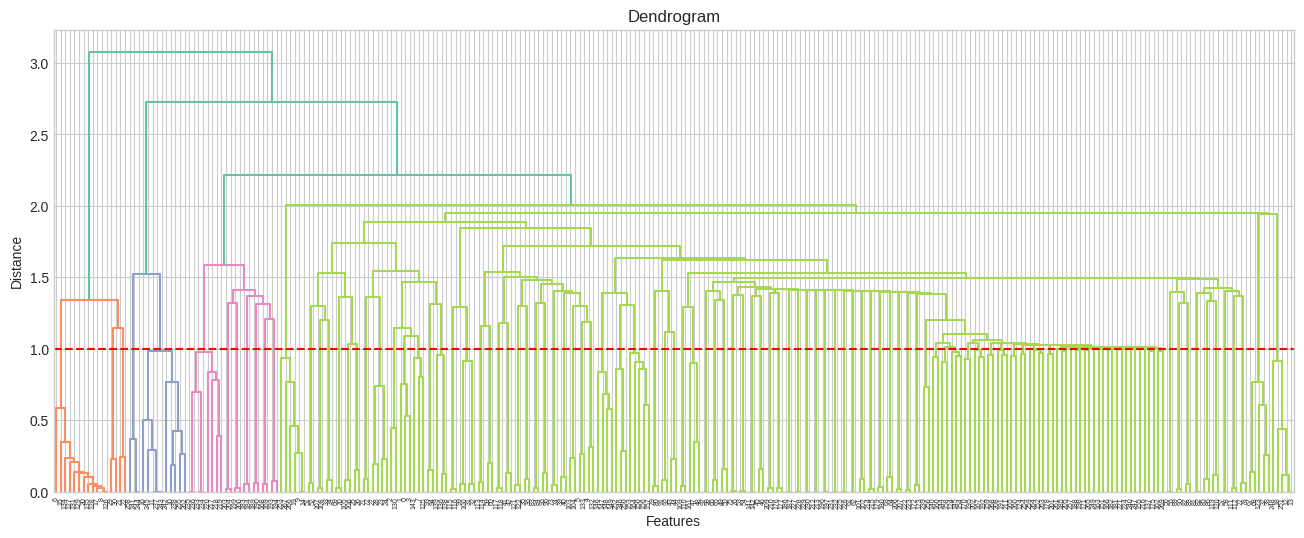

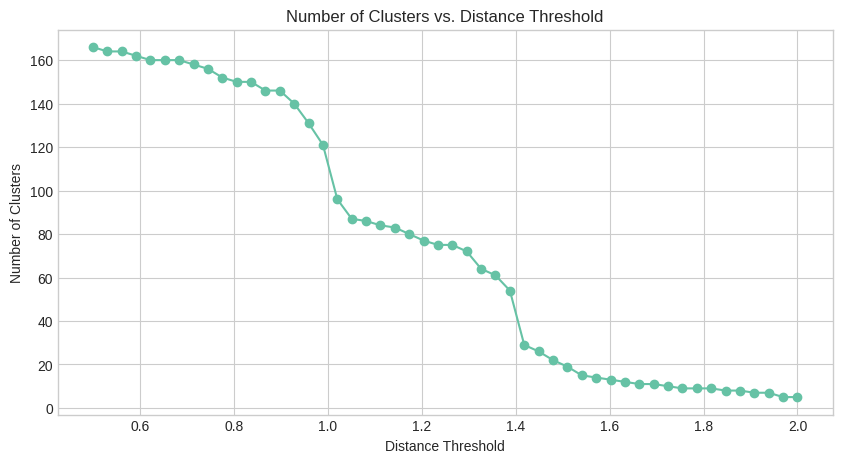

In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler

# Step 1: Function to clean and prepare data
def preprocess_data(X):
    print("✅ Original shape:", X.shape)
    # Keep only numeric columns
    X = X.select_dtypes(include=[np.number])
    # Replace inf/-inf with NaNs
    X = X.replace([np.inf, -np.inf], np.nan)
    # Fill NaNs with column mean
    X = X.fillna(X.mean())
    # Drop constant columns
    nunique = X.nunique()
    const_cols = nunique[nunique == 1].index
    X = X.drop(columns=const_cols)
    print("✅ Cleaned shape (after dropping constant columns):", X.shape)
    return X

def plot_dendrogram(X):
    # Step 1: Correlation matrix
    corr_matrix = X.corr().abs()

    # Step 2: Distance matrix
    distance_matrix = 1 - corr_matrix

    # Ensure diagonal is zero and all values are in [0, 1]
    np.fill_diagonal(distance_matrix.values, 0)
    distance_matrix = np.clip(distance_matrix, 0, 1)

    # Step 3: Convert to condensed distance matrix
    condensed_distance = squareform(distance_matrix.values, checks=False)

    # Step 4: Linkage and dendrogram
    linkage_matrix = hierarchy.linkage(condensed_distance, method='ward')

    plt.figure(figsize=(16, 6))
    hierarchy.dendrogram(linkage_matrix)
    plt.title("Dendrogram")
    plt.xlabel("Features")
    plt.ylabel("Distance")
    plt.axhline(y=1.0, color='r', linestyle='--')
    plt.show()

    return linkage_matrix

# Step 3: Plot number of clusters vs distance threshold
def plot_threshold_vs_clusters(linkage_matrix):
    thresholds = np.linspace(0.5, 2.0, 50)
    cluster_counts = [len(np.unique(hierarchy.fcluster(linkage_matrix, t=th, criterion='distance'))) for th in thresholds]

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, cluster_counts, marker='o')
    plt.title("Number of Clusters vs. Distance Threshold")
    plt.xlabel("Distance Threshold")
    plt.ylabel("Number of Clusters")
    plt.grid(True)
    plt.show()


X_clean = preprocess_data(data_encoded)
linkage_matrix = plot_dendrogram(X_clean)
plot_threshold_vs_clusters(linkage_matrix)



In [338]:
import pandas as pd

def cluster_features(X, y, num_clusters=30):
    print("Step 1: Extracting numeric columns...")
    X_numeric = X.select_dtypes(include=[np.number])

    print("Step 2: Cleaning NaNs and infs...")
    X_clean = X_numeric.replace([np.inf, -np.inf], np.nan)
    X_clean = X_clean.fillna(X_clean.mean())

    # Drop constant columns
    nunique = X_clean.nunique()
    constant_cols = nunique[nunique <= 1].index
    X_clean = X_clean.drop(columns=constant_cols)
    print(f" Step 3: Removed {len(constant_cols)} constant columns. Remaining: {X_clean.shape[1]}")

    print("Step 4: Computing correlation matrix...")
    corr_matrix = X_clean.corr().abs()

    print(" Step 5: Creating distance matrix...")
    distance_matrix = 1 - corr_matrix

    # Clip values to avoid negative distances due to numerical issues
    distance_matrix = distance_matrix.clip(lower=0.0, upper=1.0)
    condensed_distance = squareform(distance_matrix.values, checks=False)

    # Final checks before clustering
    if not np.all(np.isfinite(condensed_distance)):
        raise ValueError("Condensed distance matrix contains non-finite values!")
    if np.any(condensed_distance < 0):
        raise ValueError(" Condensed distance matrix contains negative values!")

    print(" Step 6: Performing hierarchical clustering...")
    linkage_matrix = hierarchy.linkage(condensed_distance, method='ward')

    print(" Step 7: Forming clusters...")
    clusters = hierarchy.fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    print("Step 8: Selecting representative features per cluster...")
    selected_features = []
    for cluster_id in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_columns = X_clean.columns[cluster_indices]

        # Pick feature in cluster most correlated with target
        best_feature = cluster_columns[np.argmax(X_clean[cluster_columns].corrwith(y).abs())]
        selected_features.append(best_feature)

    print(f" Step 9: Selected {len(selected_features)} features from {num_clusters} clusters.")
    return selected_features

# Apply the function to get selected features
selected_features = cluster_features(data_encoded, y, num_clusters=30)

# Combine selected features with target column y
data_selected = data_encoded[selected_features].copy()  # Copy the selected features to a new DataFrame
data_selected['admitted_ind'] = y  # Add target column

# Save the final data to a CSV file
csv_filename = 'final_selected_data.csv'
data_selected.to_csv(csv_filename, index=False)

# Output the resulting DataFrame and save to CSV
print(f"Data with selected features and target column saved to: {csv_filename}")
print(data_selected.head())  # Preview the first few rows



Step 1: Extracting numeric columns...
Step 2: Cleaning NaNs and infs...
 Step 3: Removed 11 constant columns. Remaining: 270
Step 4: Computing correlation matrix...
 Step 5: Creating distance matrix...
 Step 6: Performing hierarchical clustering...
 Step 7: Forming clusters...
Step 8: Selecting representative features per cluster...
 Step 9: Selected 30 features from 30 clusters.
Data with selected features and target column saved to: final_selected_data.csv
   mb_readmitted_ct  admission_type_Unknown  mb_admission_grp_2_ct  diabetesMed_No  metformin_No  is_clinic_or_transfer  dx_440_ind_sum  dx_707_ind_sum  dx_403_ind_sum  mb_num_procedures_ct  dx_404_ind_max  dx_396_ind_max  dx_536_ind_max  dx_304_ind_max  dx_453_ind_sum  dx_300_ind_sum  mb_number_outpatient_ct  payer_code_BC  dx_482_ind_max  dx_459_ind_sum  dx_595_ind_sum  dx_719_ind_max  gender_Male  miglitol_Steady  dx_515_ind_sum  dx_V49_ind_max  dx_V42_ind_sum  dx_790_ind_sum  dx_571_ind_sum  mb_discharge_grp_2_ct  admitted_ind
